# Работа с метриками TPR, FPR, recall и precision. Построение кривых ROC и PR

In [175]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

## 1. Загрузка и первичный анализ датасета

In [176]:
df = pd.read_csv('athletes.csv')
df.head(5)

id 
 name 
 nationality 
 sex 
 dob 
 height 
 weight 
 sport 
 gold 
 silver 
 bronze 
 
 
 
 
 0 
 736041664 
 A Jesus Garcia 
 ESP 
 male 
 10/17/69 
 1.72 
 64.0 
 athletics 
 0 
 0 
 0 
 
 
 1 
 532037425 
 A Lam Shin 
 KOR 
 female 
 9/23/86 
 1.68 
 56.0 
 fencing 
 0 
 0 
 0 
 
 
 2 
 435962603 
 Aaron Brown 
 CAN 
 male 
 5/27/92 
 1.98 
 79.0 
 athletics 
 0 
 0 
 1 
 
 
 3 
 521041435 
 Aaron Cook 
 MDA 
 male 
 1/2/91 
 1.83 
 80.0 
 taekwondo 
 0 
 0 
 0 
 
 
 4 
 33922579 
 Aaron Gate 
 NZL 
 male 
 11/26/90 
 1.81 
 71.0 
 cycling 
 0 
 0 
 0

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


## 2. Преобразование данных

### 2.1 Работа с пропущенными значениями

Проверим наличие пустых ячеек

In [178]:
df.isnull().sum()

id 0
name 0
nationality 0
sex 0
dob 1
height 330
weight 659
sport 0
gold 0
silver 0
bronze 0
dtype: int64

Пропущенные значения есть в столбцах "рост", "вес" и "дата рождения"
Для первых двух будет разумно не исключать данные из выборки, а заполнить пропуски средним значением

In [179]:
df['weight'] = df['weight'].fillna(df['weight'].mean())
df['height'] = df['height'].fillna(df['height'].mean())

После этого в датафрейме останется лишь одна строка с пустой ячейкой - в столбце 'dob'. Пожертвуем ей для упрощения кода.

In [180]:
df.dropna(axis=0,inplace=True)

Теперь в датафрейме нет пустых ячеек:

In [181]:
df.isnull().sum().sum()  # Количество всех null

0

### 2.2 Преобразование категориальных признаков

- Day of birthday

Дата рождения - категориальный признак с большим количеством уникальных значений, которые нет смысла раскидывать по отдельным столбцам с помощью get_dummies(). Чтобы сделать эти данные интерпретируемыми для модели, преобразуем дату рождения в возраст на момент единой даты. Пусть это будет 23 июня 2022 года - Международный Олимпийский день.

In [182]:
from datetime import datetime
key_day = datetime(2000,6,23)  # Фиксированная дата, разницу с которой будем считать

df['dob'] = df['dob'].apply(
    # Переводим непонятные для компьютера данные в datetime-объект, считаем возраст и записываем его в днях
    lambda x: (key_day - datetime.strptime(str(x), "%m/%d/%y")).days)
df['dob']

0 11207
1 5022
2 2949
3 3460
4 3497
 ... 
11533 1779
11534 4935
11535 3328
11536 4097
11537 3091
Name: dob, Length: 11537, dtype: int64

- Пол

Поскольку признак бинарный, его легко преобразовать

In [183]:
df['sex'] = df['sex'].apply(lambda x: 1 if x=='male' else 0)

- Национальность и вид спорта

Используем get_dummies. Заодно отбросим признаки id и name, т.к. они не должны влиять на результат предсказания.

In [184]:
df = pd.get_dummies(df[df.columns[2:]], columns=['nationality', 'sport'], drop_first=True, dummy_na=False, dtype='float')
df.head(1)

sex 
 dob 
 height 
 weight 
 gold 
 silver 
 bronze 
 nationality_ALB 
 nationality_ALG 
 nationality_AND 
 ... 
 sport_rugby sevens 
 sport_sailing 
 sport_shooting 
 sport_table tennis 
 sport_taekwondo 
 sport_tennis 
 sport_triathlon 
 sport_volleyball 
 sport_weightlifting 
 sport_wrestling 
 
 
 
 
 0 
 1 
 11207 
 1.72 
 64.0 
 0 
 0 
 0 
 0.0 
 0.0 
 0.0 
 ... 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 0.0 
 
 
 
 1 rows × 240 columns

## 3. Разбиение данных

Разделим метки и признаки. В качестве целевой переменной будем использовать пол.

In [185]:
X = df.loc[:, [i for i in df.columns if i != 'sex']]  # Всё кроме пола

In [186]:
Y = df['sex']

Теперь разделим выборку на обучающее и тестовое подмножества

In [187]:
from sklearn.model_selection import train_test_split

In [188]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

## 4. Обучение модели

In [189]:
from sklearn.linear_model import LogisticRegression

In [190]:
regmodel = LogisticRegression(max_iter=500)

In [191]:
regmodel.fit(X=X_train, y=Y_train)

LogisticRegression(max_iter=500)

Модель обучена, теперь получим предсказание по тестовой выборке.

In [192]:
# Получим результат в качестве распределения вероятностей и целочисленных значений - пригодятся оба
P_test = regmodel.predict(X_test)  # Бинарные значения
P_test_proba = regmodel.predict_proba(X_test)  # Двумерный массив вероятностей

## 5. Использование библиотеки sklearn для анализа модели

Для начала воспользуемся базовой метрикой - accuracy

In [193]:
regmodel.score(X_test, Y_test)

0.8132582322357019

### 5.1 Построение ROC-кривой

In [194]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
%matplotlib inline

In [195]:
sk_FPR, sk_TPR = roc_curve(Y_test, P_test_proba[:, 1])[:-1]  # Функция возвращает кортеж из массивов

Text(0.5, 1.0, 'ROC-кривая')

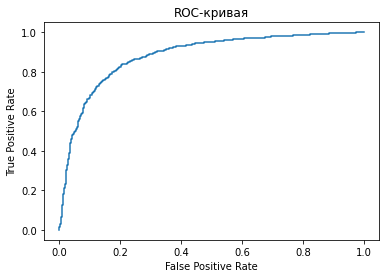

In [196]:
plt.plot(sk_FPR, sk_TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

### 5.2 Площадь под ROC-кривой

Используем встроенную функцию

In [197]:
from sklearn.metrics import roc_auc_score

In [198]:
roc_auc_score(Y_test, P_test_proba[:, 1])

0.8814904893414707

## 6. Подсчёт метрик TPR, FPR, Precision вручную

### 6.1 Матрица ошибок

Посчитаем метрики качества для классического порога активации в 0.5;
Для подсчёта нам понадобится матрица ошибок (confusion matrix)

In [199]:
tp = 0  # True positive
fp = 0  # False positive
fn = 0  # False negative
tn = 0  # True negative

In [200]:
for r, p in zip(Y_test, P_test):
    if r == p:  # real is equal to predicted
        if r == 1:  # Both are True
            tp+=1  # Верно предсказанное целевое значение
        else:  # Both are False
            tn+=1  # Верно предсказанное нецелевое значение
    else:
        if p == 0:  # real is True, False was predicted
            fn+=1  # Пропущенное целевое значение
        else:  # real is False, True was predicted
            fp+=1  # Ложное целевое значение

In [201]:
# Составим матрицу ошибок
d = {'Predicted': ['Positive', 'Negative'],'Actual Positive': [tp, fp], 'Actual Negative': [fn, tn]}
pd.DataFrame(data=d).set_index('Predicted', inplace=False, )

Actual Positive 
 Actual Negative 
 
 
 Predicted 
 
 
 
 
 
 
 Positive 
 1037 
 226 
 
 
 Negative 
 205 
 840

- True Positive Rate (Recall)

In [202]:
tp / (tp + fn)

0.8210609659540776

- False Positive Rate (Precision)

In [203]:
tp / (tp + fp)

0.8349436392914654

### 6.2 Расчёты метрик для разных пороговых значений

Для построения кривой ROC нам необходимо рассчитать FPR и TPR (Recall) для различных значений порога threshold в интервале (0, 1)
Заодно мы посчитаем Precision, который пригодится для другого графика

In [204]:
def calculate_ROC(threshold) -> tuple:
    """precision_recall_curve"""
    tp = 0
    tn = 0
    fn = 0
    fp = 0
    for r, p in zip(Y_test,
            np.where(P_test_proba[:, 1]>=threshold, 1, 0)  # Применяем "пороговую функцию"
        ):
        # После "прохождения" порога можем использовать уже написанный ранее код
        if r == p:  # real is equal to predicted
            if r == 1:  # Both are True
                tp+=1  # Верно предсказанное целевое значение
            else:  # Both are False
                tn+=1  # Верно предсказанное нецелевое значение
        else:
            if p == 0:  # real is True, False was predicted
                fn+=1  # Пропущенное целевое значение
            elif p == 1:  # real is False, True was predicted
                fp+=1  # Ложное целевое значение
    return fp/(fp + tn), tp/(tp + fn), tp/(tp + fp)

In [205]:
TPR = []
FPR = []
Precision = []
thresholds = np.linspace(0,1,200, endpoint=False)  # Пороговые значения от 0 до 1
for level in (thresholds):
    # чтобы график выходил из нуля
    metrics = calculate_ROC(level)
    FPR.append(metrics[0])
    TPR.append(metrics[1])
    Precision.append(metrics[2])
# Чтобы не делить на ноль, мы исключили пороговое значение 1. Чтобы график выходил из начала координат,
# добавим начальную точку.
FPR.append(0)
TPR.append(0)
# Для порога 1 Precision будет максимальным
Precision.append(1)

## 7. Визуализация данных и анализ модели на основе предыдущих расчётов

### 7.1 Построение ROC-кривой вручную

Объединим две ROC-кривые: построенную с помощью библиотеки sklearn и определённую на основе собственных подсчётов

Text(0.5, 1.0, 'ROC-кривая')

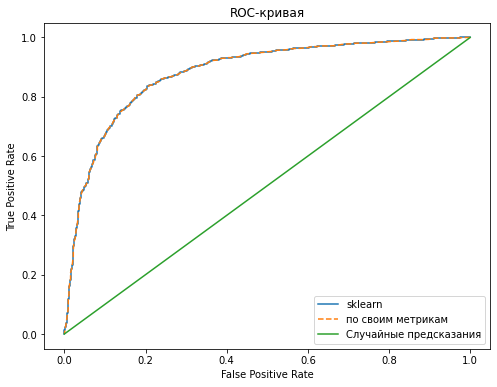

In [206]:
plt.figure(figsize=(8,6))
plt.plot(sk_FPR, sk_TPR, label = 'sklearn')
plt.plot(FPR, TPR, label = 'по своим метрикам', linestyle='--')
plt.plot([0, 1], [0, 1], label='Случайные предсказания')  # Диагональная прямая
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 0)
plt.title('ROC-кривая')

Видим, что кривые совпадают. Следовательно, мы верно реализовали алгоритм построения кривой ROC.

### 7.2 Построение графика Precision-Recall

Для графика нам нужны Precision и Recall. Первый мы уже посчитали, а второй равен True positive rate

In [207]:
Recall = TPR

Text(0, 0.5, 'precision')

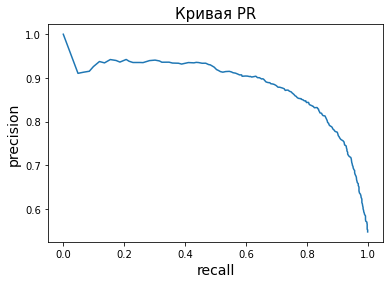

In [208]:
plt.plot(Recall, Precision)
plt.title("Кривая PR", fontsize=15)
plt.xlabel("recall", fontsize=14)
plt.ylabel("precision", fontsize=14)

Также построим кривые precision(thresholds) и recall(thresholds)

In [209]:
# Добавим элемент, чтобы состыковать размерности векторов
thresholds = np.append(thresholds, 1)

Text(0.5, 0, 'Thresholds')

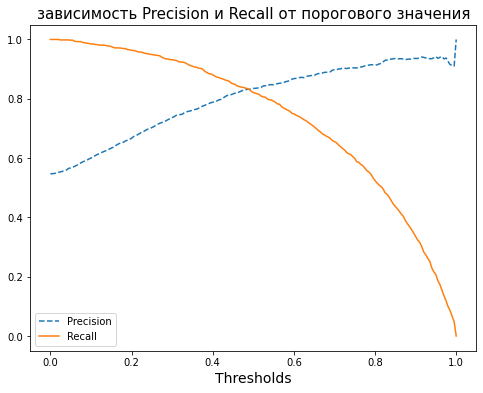

In [210]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, Precision, linestyle='--')
plt.plot(thresholds, Recall)
plt.title("зависимость Precision и Recall от порогового значения", fontsize=15)
plt.legend(["Precision","Recall"])
plt.xlabel("Thresholds", fontsize=14)

### 7.3 Расчёт ROC-AUC

Воспользуемся функцией для нахождения определённого интеграла

In [211]:
from scipy import integrate
roc_auc = - integrate.trapz(TPR, FPR)
roc_auc

0.8815605738596113

Разница со значением sklearn составляет:

In [212]:
roc_auc_score(Y_test, P_test_proba[:, 1]) - roc_auc

-7.008451814061178e-05

Менее 0.0001, что весьма неплохо

## 8. Выводы

В работе была обучена модель **Логистической регрессии** для анализа датасета **athletes**. 
- Были посчитаны метрики качества для классического порогового значения
- TPR, FPR и Precision были рассчитаны при динамическом threshold-е, что позволило построить кривые ROC и PR;
  
Результат:
- Для порога 0.5 мы имеем достаточно высокие показатели метрик;
- Собственноручно построенная кривая ROC с достаточной точностью совпадает с кривой, полученной с попощью *scikit learn*;
- AUC для двух указанных кривых тоже очень близки по значению;

### Итоги

Во-первых, модель хорошо справилась с классификацией.
Во-вторых, понятно, что, меняя пороговое значение, можно получить различный результат предсказания для одной и той же модели. Соответственно, различным сферам применения машинного обучения могут подходить разные пороги.

Анализ кривых PR и ROC, равно как и анализ площадей под графиками, позволяет оценить качество модели в целом, вне зависимости от того, в какой сфере модель будет применена.

### Может ли ROC-кривая проходить ниже диагонали?

ROC-кривая в виде прямой диагональной линии является результатом строго хаотичного предсказания. При этом, если нарочно "ухудшить" модель, можно получить кривую ниже этой диагонали.

In [213]:
# Просто заменим истинные значения меток на противоположные
worst_P = Y_test.apply(lambda x: 1 if x==0 else 0)

Проверим accuracy

In [214]:
from sklearn.metrics import accuracy_score

In [215]:
accuracy_score(Y_test, worst_P)

0.0

Да, всё плохо.

In [216]:
worst_fpr, worst_tpr = roc_curve(Y_test, worst_P)[:-1]

И для сравнения так же развернём не истинные метки, а наше предсказание: учитывая не 100-процентную точность, такое распределение будет иметь точность больше нуля

In [219]:
bad_P = pd.DataFrame(P_test)[0].apply(lambda x: 1 if x==0 else 0)

In [220]:
bad_fpr, bad_tpr = roc_curve(Y_test, bad_P)[:-1]

Наконец, посмотрим на график

Text(0.5, 1.0, 'ROC-кривая, проходящая ниже диагонали')

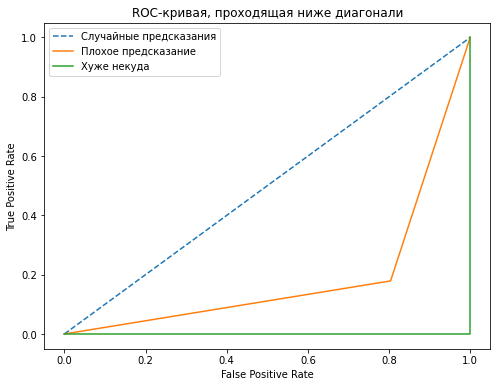

In [223]:
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], label='Случайные предсказания', linestyle='--')  # Диагональная прямая
plt.plot(bad_fpr, bad_tpr, label = 'Плохое предсказание')
plt.plot(worst_fpr, worst_tpr, label = 'Хуже некуда')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 0)
plt.title('ROC-кривая, проходящая ниже диагонали')

Как видим, ROC может проходить ниже диагонали. Правда, для этого модель должна быть обучена совершенно неправильно, и точность должна быть ниже 50%.